<a href="https://colab.research.google.com/github/minchulock/liner-pdf-chat-tutorial/blob/main/liner_pdf_chat_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8_Hyerclova_X_ver_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LINER PDF Chat Tutorial (Simple ver.)

![](https://raw.githubusercontent.com/liner-engineering/liner-pdf-chat-tutorial/main/images/liner-pdf-chat.gif)

본 튜토리얼은 **ChatGPT**를 활용해 **PDF** 파일에 기반하여 답변할 수 있는 질의응답 챗봇 코드를 다루고 있습니다. <br>
튜토리얼을 마치고 나면 위 그림과 같은 제품을 만드는 방법을 익히실 수 있게 됩니다. <br><br>

튜토리얼은 크게 **세 단계**로 나누어 진행됩니다.
- **PDF-to-Image**
- **Text Preprocessing**
- **Vector Search**


# 1. PDF-to-Text

PDF 파일에서 언어 모델이 이해할 수 있는 플레인 텍스트를 추출하는 과정입니다. <br>
해당 과정에는 PDF를 문서 이미지로 변환하는 `PDF-to-Image`, 문서 이미지에서 텍스트를 추출하는 `Image-to-Text` 로직이 포함됩니다.

## 1.1. PDF-to-Image

`PDF-to-Image`는 PDF 파일을 이미지 파일의 모음으로 변환하는 단계입니다. <br>
이 작업을 수행하기 위해 많은 기술들이 존재하지만, 본 튜토리얼에서는 [`pdf2image`](https://github.com/Belval/pdf2image)를 활용합니다. <br><br>
\* `pdf2image` 활용을 위해서는 `poppler` [설치](https://pdf2image.readthedocs.io/en/latest/installation.html)가 필요합니다.

In [ ]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 1s (267 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 120899 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.3_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.3) ...
Setting up poppler-utils (22.02.0-2ubuntu0.3) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!pip install pdf2image

In [ ]:
# pdf2image 라이브러리 임포트
from pdf2image import convert_from_path

본 튜토리얼에서는 2017년 공개된 [**Attention Is All You Need**](https://arxiv.org/abs/1706.03762) 논문을 예제 문서로 활용합니다.

In [ ]:
# 로컬 내 PDF 파일 경로 변수로 지정
FILE_NAME = "sample_data/transformer.pdf"

In [ ]:
# `convert_from_path` 함수 통해 PDF 파일 읽어와 이미지 리스트로 변환
images = convert_from_path(FILE_NAME)

In [ ]:
len(images)

15

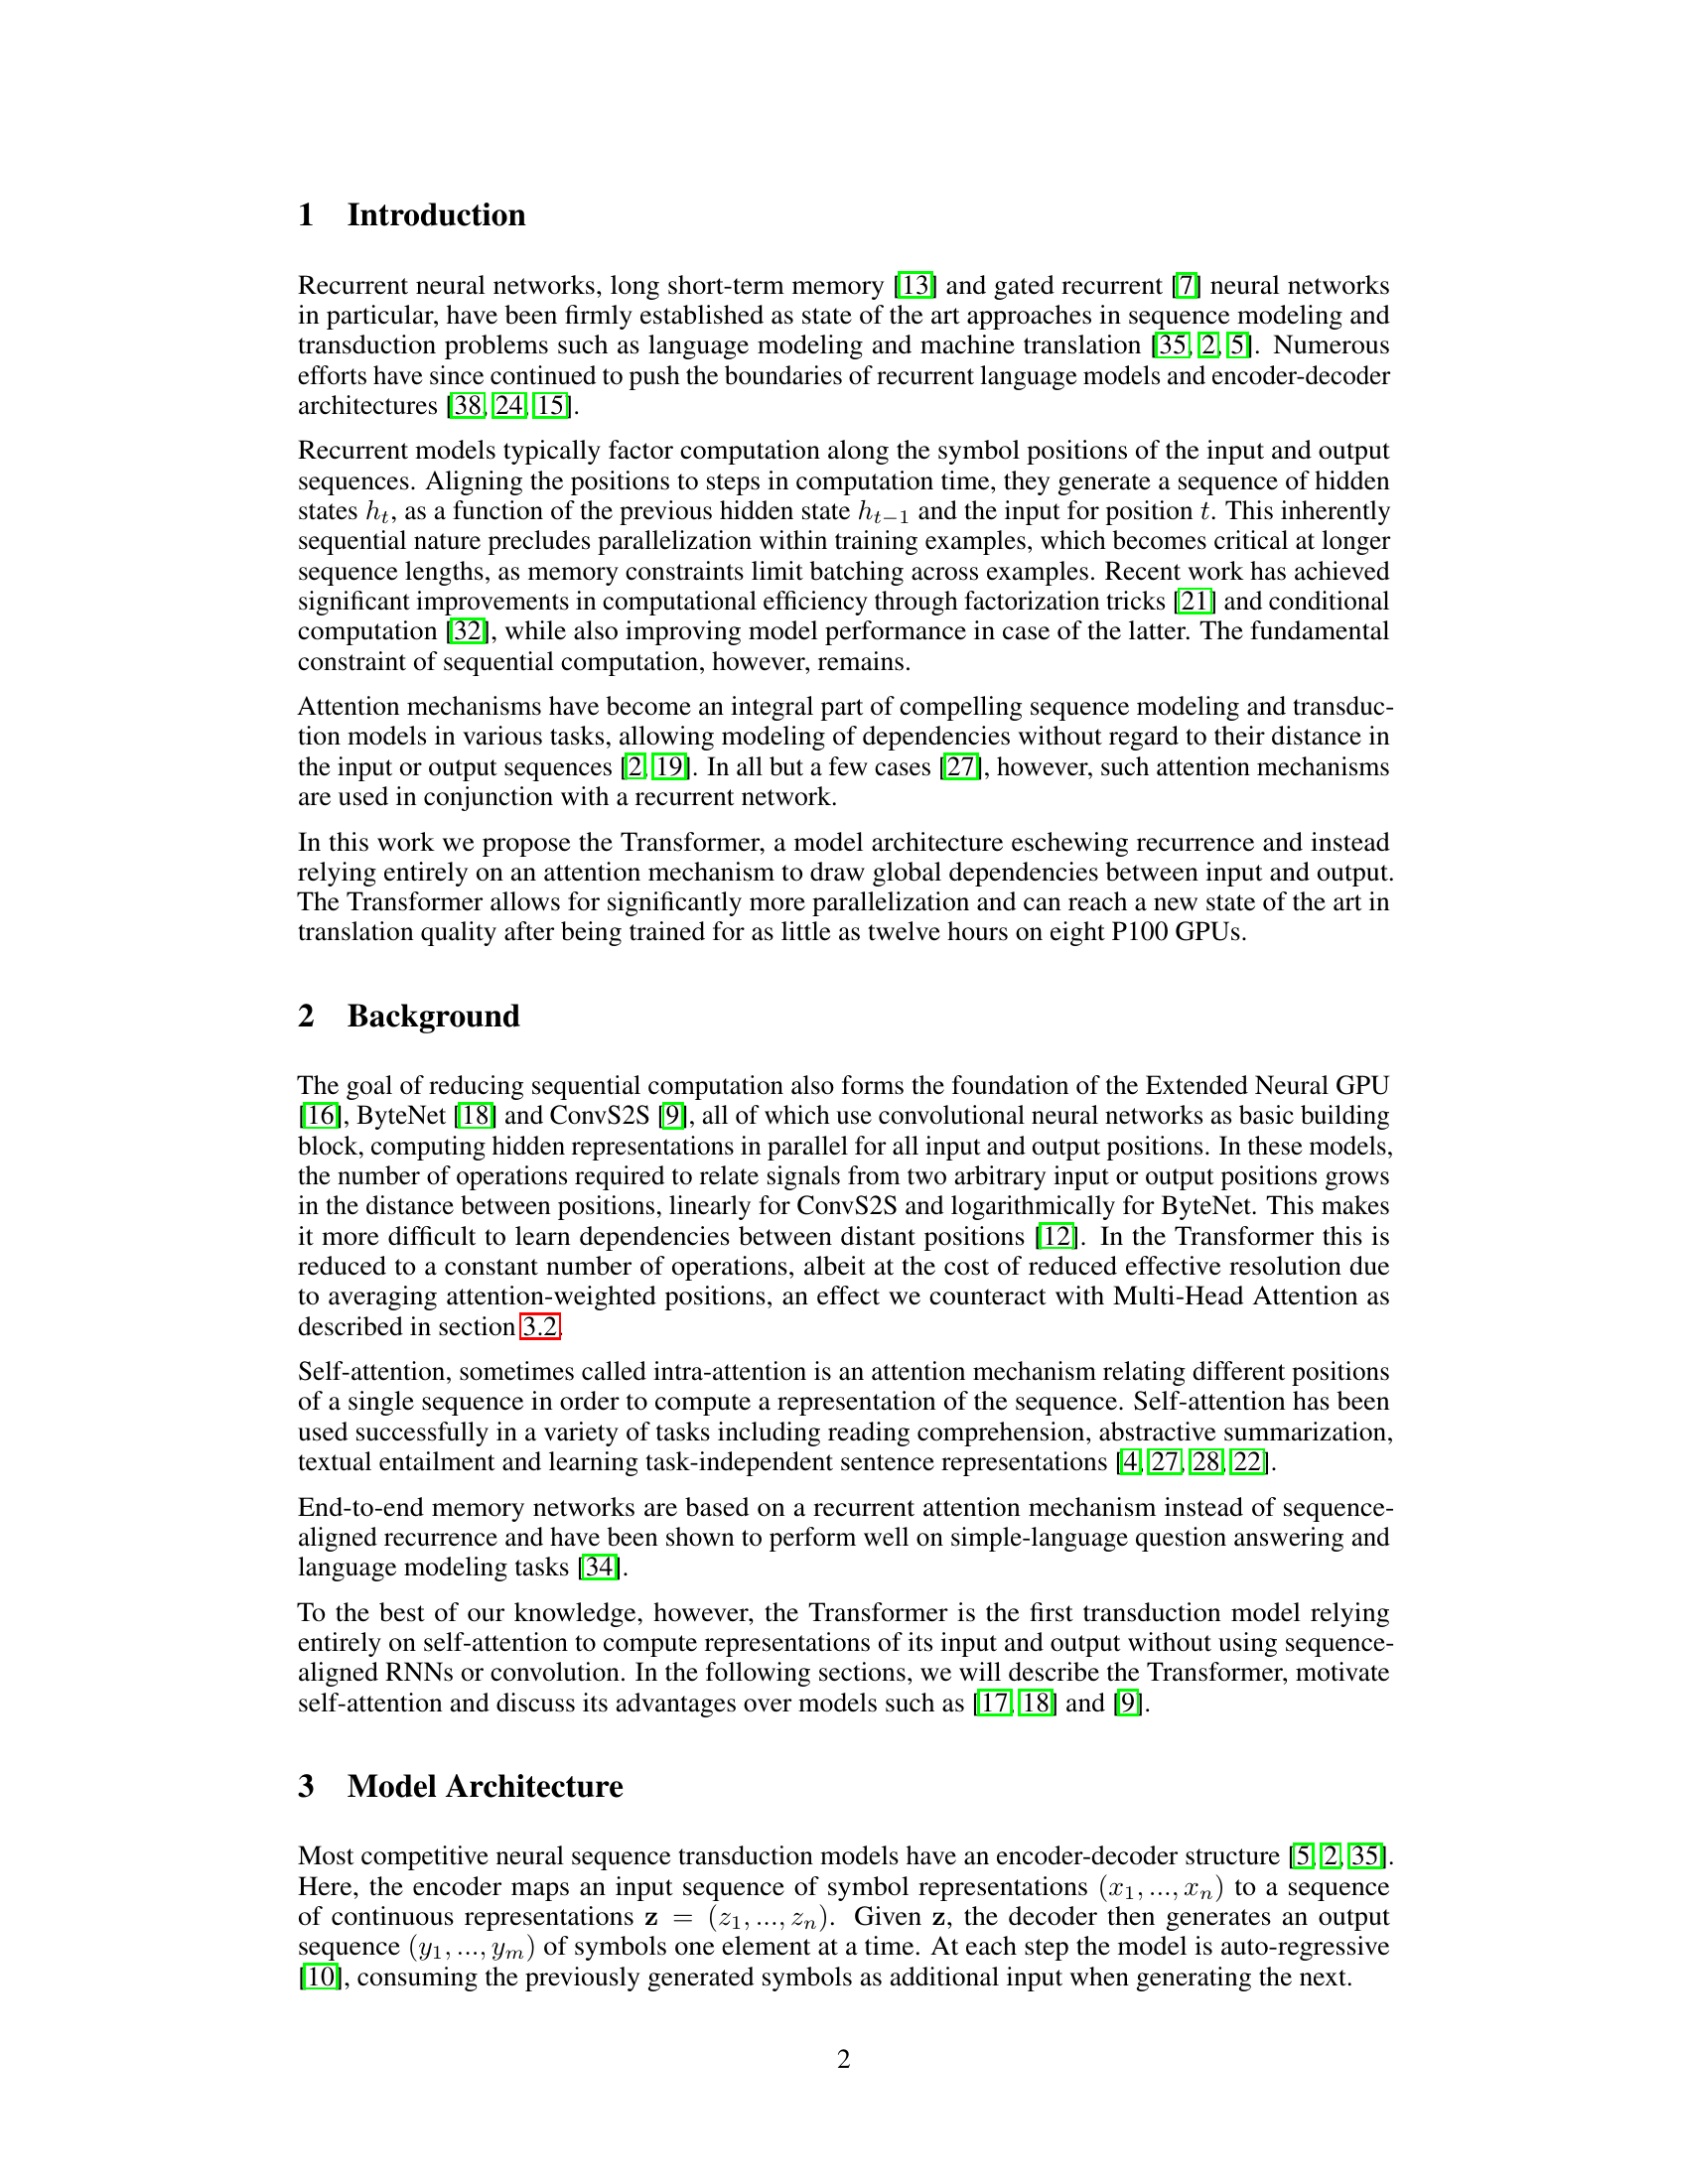

In [ ]:
# 변환된 이미지 확인
images[1]

In [ ]:
# 다음 단계를 위해 이미지 파일 로컬에 저장
for i, image in enumerate(images):
    image.save(f"page_{str(i)}.jpg", "JPEG")

## 1.2. Image-to-Text

`Image-to-Text`는 앞서 저장한 이미지 파일에서 텍스트를 추출하는 단계입니다. <br>
본 튜토리얼에서는 [`Google OCR`](https://cloud.google.com/vision/docs/ocr)을 활용하며, 기호에 따라 다른 OCR 기술 (e.g. [HuggingFace](https://huggingface.co/), [Tesseract](https://github.com/tesseract-ocr/tesseract), ...) 을 활용하실 수도 있습니다.

https://yunwoong.tistory.com/148 를 참고하여 API키 발급

In [ ]:
!pip install opencv-contrib-python
!pip install --upgrade google-cloud-vision
!pip install --upgrade google-cloud-speech
!pip install --upgrade google-cloud-language
!pip install --upgrade google-cloud-texttospeech

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.1/444.1 kB 7.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.2/275.2 kB 3.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-language
    Found existing installation: google-cloud-language 2.9.1
    Uninstalling google-cloud-language-2.9.1:
      Successfully uninstalled google-cloud-language-2.9.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.8/138.8 kB 3.4 MB/s eta 0:00:00


In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/sample_data/psychic-bliss-248504-c74da743edee.json"

In [ ]:
!echo $GOOGLE_APPLICATION_CREDENTIALS

/content/sample_data/psychic-bliss-248504-c74da743edee.json


In [ ]:
# Google OCR 라이브러리 임포트
import io
from tqdm import tqdm
from google.cloud import vision

client = vision.ImageAnnotatorClient()

In [ ]:
# Google OCR을 활용하여 이미지 파일에서 텍스트를 추출하는 메서드
def detect_text(path: str):
    with io.open(path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    return response.full_text_annotation

In [ ]:
detect_text("page_1.jpg").text

'1 Introduction\nRecurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks\nin particular, have been firmly established as state of the art approaches in sequence modeling and\ntransduction problems such as language modeling and machine translation [35 25. Numerous\nefforts have since continued to push the boundaries of recurrent language models and encoder-decoder\narchitectures [38 24 15.\nRecurrent models typically factor computation along the symbol positions of the input and output\nsequences. Aligning the positions to steps in computation time, they generate a sequence of hidden\nstates ht, as a function of the previous hidden state ht-1 and the input for position t. This inherently\nsequential nature precludes parallelization within training examples, which becomes critical at longer\nsequence lengths, as memory constraints limit batching across examples. Recent work has achieved\nsignificant improvements in computational efficiency through f

403 PermissionDenied 에러가 나면 Cloud Vision API 사용 설정을 안한 것 입니다.

Google OCR에서 내려준 결과를 곧바로 활용할 경우 위 예시와 같이 각 행의 마지막에 위치한 **띄어쓰기**, **개행** 등의 *Break* 정보가 유실된 상태의 텍스트 (e.g. `Numerous` 뒤에 불필요한 개행문자가 포함) 를 얻게 됩니다.<br>
Google도 이러한 점을 고려해 [**Break Detection**](https://cloud.google.com/dotnet/docs/reference/Google.Cloud.Vision.V1/latest/Google.Cloud.Vision.V1.TextAnnotation.Types.DetectedBreak.Types.BreakType) 기술을 제공하고 있습니다. <br>
따라서 *Break Detection* 에 의해 추론된 결과에 따라 **띄어쓰기**, **개행** 등을 올바르게 정렬하는 후처리 작업을 진행합니다.

In [ ]:
breaks = vision.TextAnnotation.DetectedBreak.BreakType

In [ ]:
dir(breaks)

['EOL_SURE_SPACE',
 'HYPHEN',
 'LINE_BREAK',
 'SPACE',
 'SURE_SPACE',
 'UNKNOWN',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

In [ ]:
# Break Detection 결과 적용을 위한 후처리 메서드
def postprocess_ocr(annotation) -> str:
    text = ""

    for page in annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        detected_break = symbol.property.detected_break
                        detected_break_type = detected_break.type_

                        if detected_break_type == breaks.UNKNOWN:
                            text += symbol.text
                        elif detected_break_type == breaks.SPACE:
                            text += f"{symbol.text} "
                        elif detected_break_type == breaks.SURE_SPACE:
                            text += f"{symbol.text} "
                        elif detected_break_type == breaks.EOL_SURE_SPACE:
                            text += f"{symbol.text} "
                        elif detected_break_type == breaks.HYPHEN:
                            text += f"{symbol.text}-"
                        elif detected_break_type == breaks.LINE_BREAK:
                            text += f"{symbol.text}\n"

    return text.strip()

*Break Detection* 정제 로직이 적용된 후처리 결과는 아래와 같습니다.

In [ ]:
postprocess_ocr(detect_text("page_1.jpg"))

'1 Introduction\nRecurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks in particular, have been firmly established as state of the art approaches in sequence modeling and transduction problems such as language modeling and machine translation [35 25. Numerous efforts have since continued to push the boundaries of recurrent language models and encoder-decoder architectures [38 24 15.\nRecurrent models typically factor computation along the symbol positions of the input and output sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden states ht, as a function of the previous hidden state ht-1 and the input for position t. This inherently sequential nature precludes parallelization within training examples, which becomes critical at longer sequence lengths, as memory constraints limit batching across examples. Recent work has achieved significant improvements in computational efficiency through factorizat

이제 모든 데이터에 **OCR**과 *Break Detection* 후처리를 적용합니다.

In [ ]:
documents = []

In [ ]:
for i in tqdm(range(len(images))):
    documents.append(
        {
            "page": int(i+1),
            "text": postprocess_ocr(detect_text(f"page_{i}.jpg")),
        }
    )

100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


In [ ]:
documents[0]

{'page': 1,
 'text': 'arXiv:1706.03762v7 [cs.CL] 2 Aug 2023\nProvided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.\nAttention Is All You Need\nAshish Vaswani* Google Brain avaswani@google.com\nLlion Jones* Google Research llion@google.com\nNoam Shazeer* Google Brain noam@google.com\nNiki Parmar* Google Research nikip@google.com\nAidan N. Gomez* † University of Toronto aidan@cs.toronto.edu\nIllia Polosukhin* *\nillia.polosukhin@gmail.com\nAbstract\nWork performed while at Google Brain.\n#Work performed while at Google Research.\nJakob Uszkoreit* Google Research usz@google.com\nŁukasz Kaiser* Google Brain\nlukaszkaiser@google.com\nThe dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We

In [ ]:
len(documents)

15

# 2. Text Pre-processing

언어 모델이 보다 잘 이해할 수 있는 단위로 텍스트 데이터를 **정제**하는 과정입니다. <br>
해당 과정에는 불필요한 텍스트를 제거하는 `Text Cleansing`, 텍스트를 보다 작은 의미 단위로 분할하는 `Text Chunking` 로직이 포함됩니다. <br>
일반적으로 문서 전처리에 따라 **서비스 품질이 크게 달라질 수 있기에** 이 과정에 튜토리얼 코드 이상으로 많은 공을 들이는게 좋습니다.

## 2.1. Text Cleansing

`Text Cleansing`은 문서 활용과 벡터화에 있어 불필요한 문자열을 제거하는 단계입니다. <br>
본 로직은 도메인 특성에 따라 다르게 작성될 수 있습니다. 본 튜토리얼에서는 **최소 단위 정제 작업**만 진행합니다. <br>
활용하시는 목적에 따라 아래 메서드에 추가 로직을 작성해주시면 됩니다.

In [ ]:
import re
from typing import List, Optional


citation_pattern = r"\[\d+\]"

def cleanse_text(text: str) -> Optional[str]:
    # 길이 단위 필터링
    if len(text) <= 5:
        return None

    # 각주 제거
    text = re.sub(citation_pattern, "", text)

    # 불필요하게 나열된 여러 개 공백 제거
    text = re.sub(" +", " ", text)
    return text

가볍게 작성한 `cleanse_text` 함수에 더러운 문자열을 넘겨 봅니다.

In [ ]:
dirty_text = """We show that the  Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large    and limited   training data.\n1 Introduction\nRecurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks in particular, have been firmly established as state of the art approaches in sequence modeling and\n*Equal contribution. Listing order is random.   Jakob proposed replacing RNNs with self-attention and started   the effort to evaluate this idea."""

In [ ]:
dirty_text

'We show that the  Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large    and limited   training data.\n1 Introduction\nRecurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks in particular, have been firmly established as state of the art approaches in sequence modeling and\n*Equal contribution. Listing order is random.   Jakob proposed replacing RNNs with self-attention and started   the effort to evaluate this idea.'

In [ ]:
cleanse_text(dirty_text)

'We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.\n1 Introduction\nRecurrent neural networks, long short-term memory and gated recurrent neural networks in particular, have been firmly established as state of the art approaches in sequence modeling and\n*Equal contribution. Listing order is random. Jakob proposed replacing RNNs with self-attention and started the effort to evaluate this idea.'

계획한 대로 불필요한 주석 기호와 공백 등이 사라지는 것을 확인할 수 있습니다.

## 2.2. Text Chunking

`Text Chunking`은 하나의 벡터에 명료하고 확실한 정보를 담기 위해 텍스트를 **의미적으로 자르는 단계**입니다. <br>
대개 문단 단위로 자르는 로직, 토큰 갯수로 자르는 로직 등이 있으며 본 튜토리얼에서는 편의상 **토큰 갯수**로 자르는 로직을 구현합니다. <br>
`Text Cleansing`과 마찬가지로 목적에 따라 다른 분할 로직을 활용하시는게 바람직합니다.

**OpenAI**는 토큰 단위 비즈니스 로직을 지원하기 위해 문장의 토큰 갯수를 반환해주는 [`tiktoken`](https://github.com/openai/tiktoken) 라이브러리를 제공합니다. <br>
본 튜토리얼에서는 `tiktoken`을 활용해 토큰 갯수 기반 청킹을 적용합니다.

In [ ]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


In [ ]:
# tiktoken 라이브러리 임포트
import tiktoken

In [ ]:
# ChatGPT 인코딩 로직인 `cl100k_base`를 기본 인코딩으로 설정
tokenizer = tiktoken.get_encoding("cl100k_base")

In [ ]:
# 입력 문장의 토큰 갯수를 카운트 하는 메서드
def num_tokens_from_text(text: str) -> int:
    num_tokens = len(tokenizer.encode(text))
    return num_tokens

In [ ]:
# 최대 토큰 갯수 지정
CHUNK_SIZE = 180

이제 각 문서를 개행 단위로 분할한 뒤, `chunk`에 더해가며 `CHUNK_SIZE`를 초과하면 `chunks`에 추가해주는 반복 로직을 수행합니다.

In [ ]:
# 토큰 갯수 단위로 문서 분할하는 메서드
def chunkify(text: str) -> List[str]:
    lines = text.split("\n")

    chunks = []

    chunk = ""
    for line in lines:
        line = cleanse_text(line)
        if line is None:
            continue

        chunk += f" {line}"

        if num_tokens_from_text(chunk) >= CHUNK_SIZE:
            chunks.append(chunk.strip())
            chunk = ""

    # 마지막 청크가 남아 있다면 추가하며 마무리
    if chunk:
        chunks.append(chunk)

    return chunks

In [ ]:
chunks = chunkify(documents[0]["text"])

In [ ]:
chunks[0]

'arXiv:1706.03762v7 [cs.CL] 2 Aug 2023 Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works. Attention Is All You Need Ashish Vaswani* Google Brain avaswani@google.com Llion Jones* Google Research llion@google.com Noam Shazeer* Google Brain noam@google.com Niki Parmar* Google Research nikip@google.com Aidan N. Gomez* † University of Toronto aidan@cs.toronto.edu Illia Polosukhin* * illia.polosukhin@gmail.com Abstract Work performed while at Google Brain. #Work performed while at Google Research. Jakob Uszkoreit* Google Research usz@google.com Łukasz Kaiser* Google Brain lukaszkaiser@google.com'

0번째 이미지가 `chunk` 단위로 쪼개진 것을 확인할 수 있습니다. <br>
이제 앞서 변환해둔 모든 문서 데이터에 `Text Chunking` 로직을 적용해줍니다.

In [ ]:
chunked_documents = []

In [ ]:
for document in documents:
    chunks = chunkify(document["text"])
    for chunk in chunks:
        chunked_documents.append(
            {
                "page": document["page"],
                "text": chunk,
            }
        )

In [ ]:
chunked_documents[0]

{'page': 1,
 'text': 'arXiv:1706.03762v7 [cs.CL] 2 Aug 2023 Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works. Attention Is All You Need Ashish Vaswani* Google Brain avaswani@google.com Llion Jones* Google Research llion@google.com Noam Shazeer* Google Brain noam@google.com Niki Parmar* Google Research nikip@google.com Aidan N. Gomez* † University of Toronto aidan@cs.toronto.edu Illia Polosukhin* * illia.polosukhin@gmail.com Abstract Work performed while at Google Brain. #Work performed while at Google Research. Jakob Uszkoreit* Google Research usz@google.com Łukasz Kaiser* Google Brain lukaszkaiser@google.com'}

이제 앞서 15개였던 문서가 Chunk 단위로 더 많은 양의 문서로 분할되었음을 확인할 수 있습니다.

In [ ]:
len(chunked_documents)

47

# 3. Vector Search

사용자 질의에 부합하는 문서를 반환 받기 위해 문서를 벡터 검색 엔진에 추가하고, 활용하는 과정입니다. <br>
문서를 벡터화하는 `Embedding`, 임베딩 된 문서를 검색해오는 `Hybrid Search` 로직이 포함됩니다.

## 3.1. Embedding

![](https://raw.githubusercontent.com/liner-engineering/liner-pdf-chat-tutorial/main/images/openai-vectors.svg)<br><br>
`Embedding`은 검색 엔진에 등록할 문서의 텍스트를 벡터로 변환하는 단계입니다. <br>
텍스트 임베딩을 위해 다양한 기술을 활용할 수 있지만, 본 튜토리얼에서는 clir-emb-dolphin Embedding을 활용합니다. <br><br>
\* 임베딩에 대한 이해를 보다 가꾸고자 하는 분은 [링크](http://jalammar.github.io/illustrated-word2vec/)를 참조해주세요.

In [ ]:
# -*- coding: utf-8 -*-

import base64
import json
import http.client


class CompletionExecutor:
    def __init__(self, host, api_key, api_key_primary_val, request_id):
        self._host = host
        self._api_key = api_key
        self._api_key_primary_val = api_key_primary_val
        self._request_id = request_id

    def _send_request(self, completion_request):
        headers = {
            'Content-Type': 'application/json; charset=utf-8',
            'X-NCP-CLOVASTUDIO-API-KEY': self._api_key,
            'X-NCP-APIGW-API-KEY': self._api_key_primary_val,
            'X-NCP-CLOVASTUDIO-REQUEST-ID': self._request_id
        }

        conn = http.client.HTTPSConnection(self._host)
        conn.request('POST', '/testapp/v1/api-tools/embedding/clir-emb-dolphin/0ec0b4b32f67496b9f92156777d4534a', json.dumps(completion_request), headers)
        response = conn.getresponse()
        result = json.loads(response.read().decode(encoding='utf-8'))
        conn.close()
        return result

    def execute(self, completion_request):
        res = self._send_request(completion_request)
        if res['status']['code'] == '20000':
            return res['result']['embedding']
        else:
            return 'Error'


if __name__ == '__main__':
    completion_executor = CompletionExecutor(
        host='clovastudio.apigw.ntruss.com',
        api_key='{api_key}',
        api_key_primary_val = '{api_key_primary_val}',
        request_id='{request_id}'
    )

    # 앞서 준비한 문서 데이터를 순회하며 벡터 추출 후, 문서 객체에 벡터 추가 할당
    for chunked_document in tqdm(chunked_documents):
        json_data = str(chunked_document["text"]).replace('"', '')
        request_data = json.loads(
            '''
            {
                "text": "''' + json_data + '''"
            }
            ''',
            strict=False
        )

        response_text = completion_executor.execute(request_data)

        chunked_document["embedding"] = response_text


100%|██████████| 47/47 [00:38<00:00,  1.23it/s]


In [ ]:
chunked_documents[0]

{'page': 1,
 'text': 'arXiv:1706.03762v7 [cs.CL] 2 Aug 2023 Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works. Attention Is All You Need Ashish Vaswani* Google Brain avaswani@google.com Llion Jones* Google Research llion@google.com Noam Shazeer* Google Brain noam@google.com Niki Parmar* Google Research nikip@google.com Aidan N. Gomez* † University of Toronto aidan@cs.toronto.edu Illia Polosukhin* * illia.polosukhin@gmail.com Abstract Work performed while at Google Brain. #Work performed while at Google Research. Jakob Uszkoreit* Google Research usz@google.com Łukasz Kaiser* Google Brain lukaszkaiser@google.com',
 'embedding': [-0.37128934,
  -0.26784477,
  -0.8056582,
  1.6386005,
  -1.0219036,
  -0.8965467,
  -0.44405332,
  1.442221,
  0.31098384,
  1.2752764,
  -0.99261963,
  1.1913544,
  1.4703878,
  1.0980588,
  -0.019949615,
  0.11634097,
  -0.9616086,
  -0.16

## 3.2. Hybrid Search

`Hybrid Search`는 사용자 질의에 따라 레퍼런스가 될 수 있는 문서를 검색하는 단계입니다. <br>
23년 기준 많은 벡터 서치 엔진이 개발되고 있지만, 현재 기준 개발 편의성이 가장 높은 [**Pinecone**](https://www.pinecone.io/)을 활용합니다.

![](https://raw.githubusercontent.com/liner-engineering/liner-pdf-chat-tutorial/main/images/pinecone-index.png)

먼저 **Pinecone**에서 활용할 인덱스를 생성해줍니다. <br>
clir-emb-dolphin embedding 이 **1024차원**의 벡터를 반환하므로 해당 값을 `Dimensions`에, 유사도 검색에 활용하고자 하는 메트릭을 `Metric`에 선택해주면 됩니다.

![](https://raw.githubusercontent.com/liner-engineering/liner-pdf-chat-tutorial/main/images/before-upsert.png)

인덱스가 생성된 후, **`Index Info`** 드롭다운을 열어주면 아직 등록된 벡터가 없는 것을 확인할 수 있습니다.<br>
이제 앞서 생성한 벡터 정보를 해당 인덱스에 등록해주는 작업을 진행합니다.

In [ ]:
!pip install pinecone-client

In [ ]:
# pinecone 라이브러리 임포트
import pinecone

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# pinecone API Key 설정
pinecone.init(api_key="{api_key}", environment="gcp-starter")

In [ ]:
# pinecone 등록 인덱스 확인
active_indexes = pinecone.list_indexes()

아래 변수에 앞서 생성한 **Pinecone Index**가 담겨 있어야 합니다.

In [ ]:
active_indexes

['classnow']

이제 문서 데이터를 **Pinecone**에 등록하기 위해 벡터 데이터를 튜플 형태로 생성합니다.

In [ ]:
vectors = [
    (
        f"vec{str(i)}",                  # 문서 아이디
        chunked_document["embedding"],   # 벡터
        {                                # 문서 메타 정보 딕셔너리
            "text": chunked_document["text"],
            "page": chunked_document["page"],
            "file": FILE_NAME,
        },
    )
    for i, chunked_document in enumerate(chunked_documents)
]

In [ ]:
vectors[0]

('vec0',
 [-0.37128934,
  -0.26784477,
  -0.8056582,
  1.6386005,
  -1.0219036,
  -0.8965467,
  -0.44405332,
  1.442221,
  0.31098384,
  1.2752764,
  -0.99261963,
  1.1913544,
  1.4703878,
  1.0980588,
  -0.019949615,
  0.11634097,
  -0.9616086,
  -0.16662025,
  0.49045077,
  0.92958117,
  -0.13362026,
  -0.35808387,
  1.2873862,
  0.9919421,
  1.3698806,
  -1.1420094,
  -1.1406015,
  -0.44808114,
  0.66965413,
  1.023345,
  0.24095337,
  1.2916403,
  -0.56883097,
  -0.47931674,
  1.38286,
  0.23105387,
  -0.9460309,
  -0.9503196,
  -0.49022228,
  -0.21538185,
  -0.6886285,
  -1.694659,
  0.020993738,
  -0.14788072,
  0.040288683,
  0.85585463,
  -1.6240941,
  -1.3900726,
  -0.03554397,
  -1.2503042,
  0.42640692,
  0.07795183,
  -0.19451125,
  -0.73830706,
  0.7800027,
  -1.3707095,
  1.1823418,
  0.6793509,
  -1.5847721,
  -0.88162583,
  1.6205302,
  1.2443165,
  -0.449051,
  0.6044323,
  0.39474413,
  -0.8256919,
  0.6980785,
  -1.0689384,
  0.4712776,
  -0.6115088,
  0.9841754,
  -

In [ ]:
len(vectors)

47

In [ ]:
# 인덱스 설정
index = pinecone.Index("classnow")

# 설정된 인덱스에 앞서 생성한 벡터 데이터 Upsert
index.upsert(
    vectors=vectors,
    namespace="pdf_vectors",
)

{'upserted_count': 47}

![](https://raw.githubusercontent.com/liner-engineering/liner-pdf-chat-tutorial/main/images/after-upsert.png)

방금 `upsert` 작업을 통해 **36개**의 벡터가 인입되었습니다. <br>
이제 검색 엔진이 사용자 쿼리에 부합하는 문서 데이터를 가져오는지 확인해보겠습니다.

In [ ]:
# 사용자 쿼리 벡터화 위한 메서드
def query_embed(text: str) -> List[float]:
    json_data = str(text).replace('"', '')
    request_data = json.loads(
        '''
        {
            "text": "''' + json_data + '''"
        }
        ''',
        strict=False
    )
    response_text = completion_executor.execute(request_data)

    return response_text

In [ ]:
# 사용자 쿼리 벡터화
query_vector = query_embed("What advantages do transformers have over RNNs?")

In [ ]:
# 사용자 쿼리 벡터와 `filter` 로직을 활용해 Hybrid Search
query_response = index.query(
    namespace="pdf_vectors",
    top_k=10,
    include_values=True,
    include_metadata=True,
    vector=query_vector,
    filter={
        "file": {"$in": [FILE_NAME]},
    }
)

위 코드를 보면 `query_vector` 외에도 `filter` 인자를 추가로 넘겨주는 것을 확인할 수 있습니다. <br>
`filter` 인자에 따라 특정 **file** 명을 지닌 문서 데이터 중에서 가장 유사한 문서를 반환하게끔 하는 **Hybrid Search** 적용이 가능해집니다.

In [ ]:
# Top-1으로 매칭된 데이터 확인
query_response["matches"][0]["metadata"]

{'file': 'sample_data/transformer.pdf',
 'page': 10.0,
 'text': 'WSJ 23 F1 88.3 increased the maximum output length to input length + 300. We used a beam size of 21 and a = 0.3 for both WSJ only and the semi-supervised setting. Our results in Table 4 show that despite the lack of task-specific tuning our model performs sur-prisingly well, yielding better results than all previously reported models with the exception of the Recurrent Neural Network Grammar . In contrast to RNN sequence-to-sequence models , the Transformer outperforms the Berkeley-Parser even when training only on the WSJ training set of 40K sentences. 7 Conclusion In this work, we presented the Transformer, the first sequence transduction model based entirely on attention, replacing the recurrent layers most commonly used in encoder-decoder architectures with multi-headed self-attention. For translation tasks, the Transformer can be trained significantly faster than architectures based on recurrent or convolutional laye

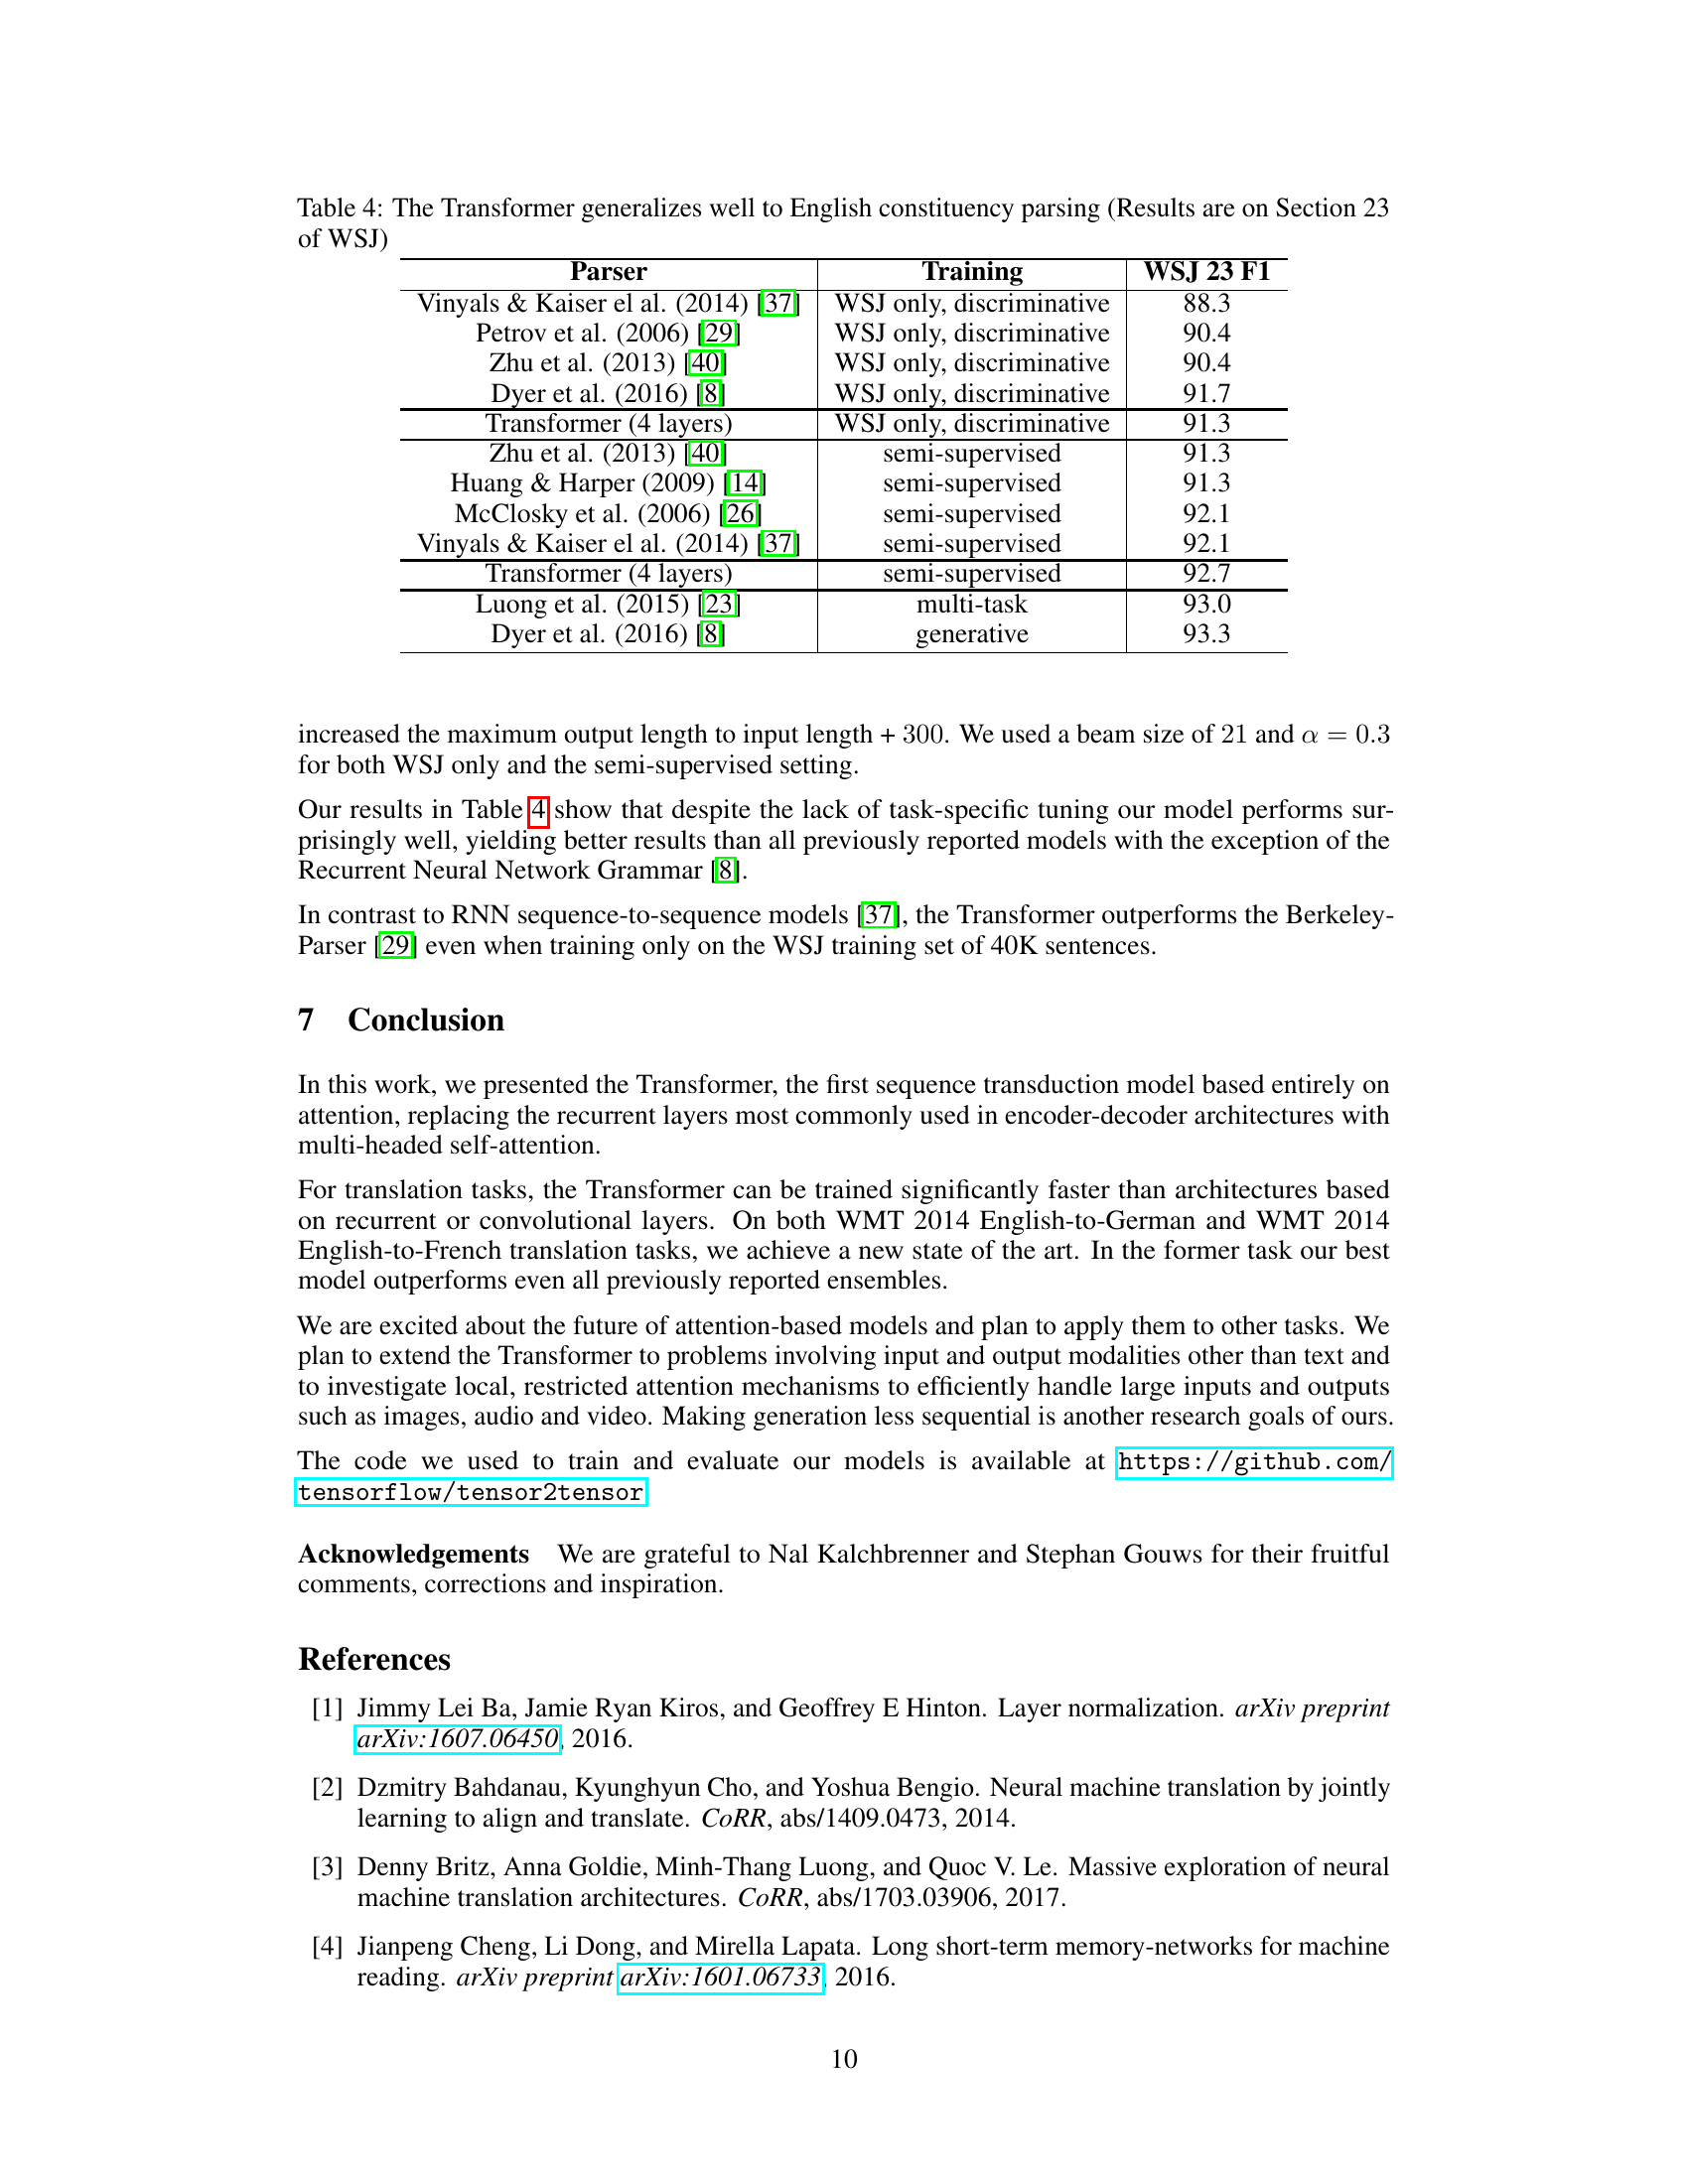

In [ ]:
# PDF 중 몇 번째 페이지에서 근거를 찾을 수 있었는지 확인
images[int(query_response["matches"][0]["metadata"]["page"])-1]

# Simple PDF Chat

이제 기본적인 기능 구현을 위한 로직들의 개발이 완료되었습니다. <br>
최종적으로 아래와 같은 함수를 구현해 위 모든 과정을 하나의 로직으로 통합할 수 있습니다.

In [ ]:
import requests

class Child_CompletionExecutor(CompletionExecutor):
    def _send_request(self, completion_request):
        headers = {
            'X-NCP-CLOVASTUDIO-API-KEY': self._api_key,
            'X-NCP-APIGW-API-KEY': self._api_key_primary_val,
            'X-NCP-CLOVASTUDIO-REQUEST-ID': self._request_id,
            'Content-Type': 'application/json; charset=utf-8'
        }

        # Initialize result variable
        result = None

        try:
            # Use requests.post for making an HTTP POST request
            # Base model /testapp/v1/chat-completions/HCX-002
            # Tunning model
            response = requests.post(
                f"{self._host}/testapp/v1/chat-completions/HCX-002",
                headers=headers, json=completion_request, stream=False
            )

            # Check if the request was successful (status code 200)
            if response.status_code == 200:
                result = response.json()
            else:
                print(f"Request failed with status code: {response.status_code}")
        except requests.RequestException as e:
            # Handle exceptions, log, or raise accordingly
            print(f"Request failed: {e}")

        return result


    def execute(self, completion_request):
        res = self._send_request(completion_request)

        if res['status']['code'] == '40103':
            # Check whether the token has expired and reissue the token.
            self._access_token = None
            return self.execute(completion_request)
        elif res['status']['code'] == '20000':
            return res['result']['message']['content']
        else:
            return 'Error'


In [ ]:
def pdf_chat(query: str) -> str:
    # 1. 사용자 쿼리 벡터화
    query_vector = query_embed(query)

    # 2. Hybrid Search 통해 레퍼런스 문서 반환
    query_response = index.query(
        namespace="pdf_vectors",
        top_k=10,
        include_values=True,
        include_metadata=True,
        vector=query_vector,
        filter={
            "file": {"$in": [FILE_NAME]},
        },
    )

    reference = query_response["matches"][0]["metadata"]

    # 3. 프롬프트에 레퍼런스 문서 정보와 사용자 쿼리 정보 입력
    child_completion_executor = Child_CompletionExecutor(
        host='https://clovastudio.stream.ntruss.com',
        api_key='{api_key}',
        api_key_primary_val='{api_key_primary_val}',
        request_id='{request_id}'
    )

    preset_text = [{"role": "system", "content": "\n".join([
                "Your role is to answer the user's query based on the references provided.",
                "You must base your answer solely on the references, regardless of your own knowledge, and you must include the page information in your answer.",
            ])},
            {"role": "system", "content": f"reference: {reference['text']}, page: ({int(reference['page'])})"},
            {"role": "user", "content": query}]

    request_data = {
        'messages': preset_text,
        'topP': 0.8,
        'topK': 0,
        'maxTokens': 256,
        'temperature': 0.5,
        'repeatPenalty': 5.0,
        'stopBefore': [],
        'includeAiFilters': True
    }

    # 4. LLM 생성 답변 반환
    response_text = child_completion_executor.execute(request_data)

    return response_text

In [ ]:
response = pdf_chat("What advantages do transformers have over RNNs?")

In [ ]:
response

'Transformers offer several advantages over RNNs as mentioned in the reference text:\n\n1. Significantly faster training times: Transformers can be trained much faster than architectures based on recurrent or convolutional layers due to their efficient use of attention mechanisms.\n\n2. Better performance without task-specific tuning: The Transformer model achieves better results than previously reported models, including RNNs, even without any task-specific tuning. This shows its ability to generalize well across different tasks.\n\n3. Outperforms RNNs on smaller datasets: The Transformer model outperforms the Berkeley Parser and other RNN-based models when trained only on the smaller WSJ training set of 40K sentences.\n\n4. State-of-the-art results on translation tasks: The Transformer model sets a new state of the art on both WMT 2014 English-to-German and WMT 2014 English-to-French translation tasks, achieving better results than previous models, including those using RNNs. In the 

# Future Work

본 튜토리얼에 소개된 기능 외에도 추가적으로 아래와 같은 기능을 구현해볼 수 있습니다.

- **Multi-turn Chat**: 싱글 턴 대화가 아닌 멀티 턴 대화를 이어나가기 위해 대화 이력을 관리 및 활용해볼 수 있습니다.
- **Query Refinement**: 검색 로직을 개선하기 위해 쿼리를 정제 및 강화해주는 로직을 더해볼 수 있습니다.
- **Term-based Search**: 필터, 벡터 기반 검색 외 키워드 기반 검색을 더해볼 수 있습니다.

# Contributors

- [minchul ock](mc.ock@navercorp.com)

본 내용의 원본은 [liner-pdf-chat-tutorial](https://github.com/liner-engineering/liner-pdf-chat-tutorial) 의 Ada V2 Embedding 과 chatgpt 사용을 네이버클라우드에서 제공하는 Embedding API 와 Hyperclova X chatbot 을 이용하여 각색 하였습니다.